# Chapter 5

## 5.4.2 - Embedding Initialization Methods

Comparing Initialization Methods for the `new_tokens` added

In [1]:
# -------------------------------------------------------------------
#                       STEP 1. Fetch a dataset
#
# In step 1 we're fetching a dataset and selecting a random number of lines which CONTAIN any added token

# Imports
import os
import tqdm
import numpy as np
import pandas as pd
import hack_tokenizer
import hack_tokenizer.utils.constants as C
np.random.seed(42)
CHOSEN_LINES = None
CHOSEN_TOKENS = {}
NEW_TOKENS = None
with open(C.DATA_DIR / 'tokenizer_pt-pt.txt', 'r') as f:
    DATASET_TOKENIZER = f.readlines()

def calculate_token_scores(model, tokenizer, phrase: str, token_id: int):
    '''
    Returns the score of a specific token_id when generating a new token with `phrase` as input.

    Parameters
    ----------
    model: Any
        model to generate the phrase with
    
    tokenizer: Any
        tokenizer to encode the given phrase
    
    phrase: str
        phrase to give as input to the model
    
    token_id: int
        token to retrieve the scores to

    Returns
    -------
    dict[Literal['score', 'rank', 'best_score'], float]
    '''
    inputs = tokenizer(phrase, return_tensors='pt')
    for key in inputs.keys(): inputs[key] = inputs[key].to(model.device)
    generation = model.generate(
        inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        pad_token_id = tokenizer.eos_token_id,
        output_scores=True,
        return_dict_in_generate=True,
        max_new_tokens=1,
    )
    scores = generation['scores'][0][0]
    token_score = scores[token_id]
    token_rank = (scores > token_score).sum()
    return {'score': token_score.item(), 'rank': token_rank.item(), 'best_score': scores.max().item()}

def choose_random_line(file, file_size: int) -> bytes:
    """
    Seek to a random byte position and return the next full line.
    
    Args:
        file: A file object opened in binary mode.
        file_size: The total size of the file in bytes.
        
    Returns:
        A full line (bytes), starting from the next newline after the random byte.
    """
    byte_pos = np.random.randint(0, file_size - 1)
    file.seek(byte_pos)
    
    # Skip partial line
    file.readline()
    
    # Return the next full line
    return file.readline()

def sample_lines(file_path: str, sample_size: int, musthave_chars_list: list[str]) -> list[str]:
    """
    Randomly sample a given number of unique lines from a large file.
    
    Args:
        file_path: Path to the file.
        sample_size: Number of unique lines to sample.
        
    Returns:
        A list of decoded strings (lines).
    """
    global CHOSEN_LINES
    if CHOSEN_LINES is not None:
        return CHOSEN_LINES
    file_size = os.path.getsize(file_path)
    # Find #SAMPLE_SIZE phrases containing any of the new tokens
    selected_lines = set()
    with open(file_path, 'rb') as f:
        while len(selected_lines) < sample_size:
            line = choose_random_line(f, file_size)
            if line and line.strip() and any(t in line.decode() for t in musthave_chars_list):  # Ignore empty lines and lines which don't contain any added token
                selected_lines.add(line.decode())
    CHOSEN_LINES = list(selected_lines)
    return CHOSEN_LINES

def print_prefix(model: str, method: str, start: pd.Timestamp):
    timestamp_print = f'{pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")} | {(pd.Timestamp.now() - start).total_seconds():<5.2f} sec'
    return f'[`{model}`/{"`"+method+"`":<17s} @ {timestamp_print}]'

def analyze_init_method(model_name: str, num_new_tokens: int, embed_init_method: str, dataset_path: str, sample_size: int):
    global CHOSEN_TOKENS, NEW_TOKENS
    start = pd.Timestamp.now()
    print_args = [model_name, embed_init_method, start]
    print(f'{print_prefix(*print_args)} - Initializing model and tokenizer')
    # "Hacking" a model and training a tokenizer to get "new_tokens"
    model, tokenizer   = hack_tokenizer.utils.loader.load_model_and_tokenizer(model_name, C.DEVICE)
    encoding_tokenizer = hack_tokenizer.utils.loader.load_model_and_tokenizer(model_name, C.DEVICE)[1]
    hacker = hack_tokenizer.hack.ModelHacker(dataset=C.DATASET_TOKENIZER, batch_size=C.GENERATION_BATCH_SIZE)

    print(f'{print_prefix(*print_args)} - Hacking model and tokenizer')
    model, tokenizer = hacker.hack(
        model, tokenizer,
        encoding_tokenizer,
        num_tokens=num_new_tokens,
        embed_initializer_method=embed_init_method,
        show_progress=False,
        train=False,
    )

    assert NEW_TOKENS is None or all(t in NEW_TOKENS for t in hacker.new_tokens)
    NEW_TOKENS = set(t for t in hacker.new_tokens)

    # Select lines
    lines = sample_lines(dataset_path, sample_size, hacker.new_tokens)

    # Iterate over them
    scores = []
    for line in tqdm.tqdm(lines, desc=f'{print_prefix(*print_args)} - Analyzing results'):
        # Pick a random `new_token` in `line` to simulate a generation for it
        new_tokens_in_line = [t for t in hacker.new_tokens if t in line]
        # Find the random token for the line
        split_token = CHOSEN_TOKENS.get(line, np.random.choice(new_tokens_in_line, 1)[0].item())
        # Update the random token for the line
        CHOSEN_TOKENS[line] = split_token
        split_token = np.random.choice(new_tokens_in_line, 1)[0].item()   # Randomly choose a token to split the word on
        splitted_line = line.split(split_token)
        eval_phrase = splitted_line.pop(0)
        while len(eval_phrase) < 10 and len(splitted_line) > 0:    # While we don't have 10 characters, continuously expand the phrase
            eval_phrase += split_token + splitted_line.pop(0)
        # Calculate the score for it
        scores.append(calculate_token_scores(model, encoding_tokenizer, eval_phrase, tokenizer.encode(split_token)))
    print(f'{print_prefix(*print_args)} - Finished Analysis')
    return scores


import json
import os

SAMPLE_SIZE = 1_000
MODEL = 'HuggingFaceTB/SmolLM2-135M'
NUMBER_NEW_TOKENS = C.NUMBER_NEW_TOKENS
DATASET_PATH = C.DATA_DIR / 'FULL_opensubtitles_pt-pt.txt'
AVAILABLE_INIT_METHODS = [
    'random',
    'mean',
    'min',
    'max',
    'quantile(0.25)', 'quantile(0.5)', 'quantile(0.75)'
] + [f'weighted_drop({i/10:.1f})' for i in range(5, 51, 5)]

# Results path (to store results as it takes a bit of time to run)
RQ124_RESULTS_PATH = 'RQ_1.2.4_Results.json'

# Iterating over all available init methods
if not os.path.isfile(RQ124_RESULTS_PATH):
    results = {}
    for embed_init_method in AVAILABLE_INIT_METHODS:
        results[embed_init_method] = analyze_init_method(MODEL, NUMBER_NEW_TOKENS, embed_init_method, DATASET_PATH, SAMPLE_SIZE)
    with open(RQ124_RESULTS_PATH, 'w') as f:
        json.dump(results, f, indent=4)

with open(RQ124_RESULTS_PATH, 'r') as f:
    results = json.load(f)

df = []
for key in results.keys():
    for n, i in enumerate(results[key]):
        i.update({'method': key, 'phrase_id': n})
    df += results[key]
df = pd.DataFrame(df)


# Count number of times each method is "number 1" in rank (meaning how many times each method had the lowest "rank")
min_values = df.groupby(by=['phrase_id'], as_index=False)[['rank']].min()
df = df.merge(min_values, how='left', on=['phrase_id'], suffixes=('', '_min'))
df['min_ranked'] = df['rank'] == df['rank_min']
evaluation = df.groupby(by=['method'])['min_ranked'].sum()

pd.options.plotting.backend = "plotly"

# evaluation.plot(kind='bar', y='min_ranked')


# df.pivot(
#     index='phrase_id', columns='method', values='rank'
# ).reset_index()


# df.plot(x='phrase_id', figsize=(20, 10), logy=True, logx=True)
print(evaluation.to_markdown())

| method             |   min_ranked |
|:-------------------|-------------:|
| max                |           39 |
| mean               |           36 |
| min                |          100 |
| quantile(0.25)     |           96 |
| quantile(0.5)      |           31 |
| quantile(0.75)     |           32 |
| weighted_drop(0.5) |           26 |
| weighted_drop(1.0) |           37 |
| weighted_drop(1.5) |           47 |
| weighted_drop(2.0) |           53 |
| weighted_drop(2.5) |           81 |
| weighted_drop(3.0) |           89 |
| weighted_drop(3.5) |           79 |
| weighted_drop(4.0) |           99 |
| weighted_drop(4.5) |          126 |
| weighted_drop(5.0) |          127 |


# Chapter 6

## 6.1 Motivation

Gathering results for the chapter 6.1 - Motivation.

These should be results showcasing that a model after being "hacked" can't have the "default" inference, because it simply alucinates

In [2]:
from hack_tokenizer import hack, loader
from hack_tokenizer.utils import constants as C
from hack_tokenizer.utils.cli import Colors

C.MODEL = 'HuggingFaceTB/SmolLM2-135M'
DATASET_TOKENIZER = C.DATA_DIR / 'tokenizer_pt-pt.txt'
NUM_NEW_TOKENS = 10000
MAX_NEW_TOKENS = 20
PROMPTS = [
    'Olá, podes contar-me um poema com as palavras: Sol, Lua, Céu e Nuvens?',
    'Bacalhau é um dos peixes mais utilizados na culinária'
]

print(f'''{Colors.WHITE.bold}Run Configs: {Colors.RESET}
  - {Colors.CYAN}model:{Colors.YELLOW} {C.MODEL}{Colors.RESET}
  - {Colors.CYAN}device:{Colors.YELLOW} {C.DEVICE}{Colors.RESET}
  - {Colors.CYAN}model_kwargs:{Colors.YELLOW} {{'torch_dtype': torch.bfloat16}}{Colors.RESET}
  - {Colors.CYAN}tokenizer_kwargs:{Colors.YELLOW} {{}}{Colors.RESET}
  - {Colors.CYAN}Tokenizer (BPE) Dataset:{Colors.YELLOW} `{DATASET_TOKENIZER}`{Colors.RESET}
  - {Colors.CYAN}Batch Size:{Colors.YELLOW} {C.GENERATION_BATCH_SIZE}{Colors.RESET}
  - {Colors.CYAN}Learning Rate:{Colors.YELLOW} {C.LEARNING_RATE} (we won't train the model here, however),{Colors.RESET}
  - {Colors.CYAN}# Added Tokens:{Colors.YELLOW} {NUM_NEW_TOKENS}{Colors.RESET}
  - {Colors.CYAN}Embeddings Init Method:{Colors.YELLOW} {C.EMBED_INIT_METHOD}{Colors.RESET}
  - {Colors.CYAN}Maximum New Tokens:{Colors.YELLOW} {MAX_NEW_TOKENS}{Colors.RESET}
''')
model, tokenizer = loader.load_model_and_tokenizer(C.MODEL, C.DEVICE)
encoding_tokenizer = loader.load_model_and_tokenizer(C.MODEL, C.DEVICE)[1]
with open(DATASET_TOKENIZER, 'r') as f:
    tokenizer_train_data = f.readlines()
hacker = hack.ModelHacker(
    tokenizer_train_data,
    C.GENERATION_BATCH_SIZE,
    C.LEARNING_RATE
)

Run Configs: 
  - model: HuggingFaceTB/SmolLM2-135M
  - device: cuda
  - model_kwargs: {'torch_dtype': torch.bfloat16}
  - tokenizer_kwargs: {}
  - Tokenizer (BPE) Dataset: `/home/yali/MEGA/Hack The Tockenizer/data/tokenizer_pt-pt.txt`
  - Batch Size: 8
  - Learning Rate: 1e-06 (we won't train the model here, however),
  - # Added Tokens: 10000
  - Embeddings Init Method: weighted_drop(1.5)
  - Maximum New Tokens: 20



Default generation BEFORE hacking

In [3]:
for prompt in PROMPTS:
    inputs = tokenizer(prompt, return_tensors='pt')
    output = model.generate(
        inputs['input_ids'].to(model.device),
        attention_mask=inputs['attention_mask'].to(model.device),
        max_new_tokens = MAX_NEW_TOKENS,
        pad_token_id = tokenizer.eos_token_id,
        do_sample=False,
        temperature=None
    )
    generated_text = tokenizer.decode(output[0][inputs['input_ids'].shape[1]:]).replace(prompt, '')    # Removing "prompt" from output
    print(f'{"":-^100s}\n{Colors.RED}<PROMPT>{Colors.YELLOW}{prompt}{Colors.RED}</PROMPT><GENERATION>{Colors.CYAN}{generated_text}{Colors.RED}</GENERATION>{Colors.RESET}\n{"":-^100s}')

----------------------------------------------------------------------------------------------------
<PROMPT>Olá, podes contar-me um poema com as palavras: Sol, Lua, Céu e Nuvens?</PROMPT><GENERATION>

Ao fazer isso, o poeta deve ter uma palavra</GENERATION>
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
<PROMPT>Bacalhau é um dos peixes mais utilizados na culinária</PROMPT><GENERATION>.

Ao entender a criatura dos peixes, o uso de</GENERATION>
----------------------------------------------------------------------------------------------------


(hacking model)

In [4]:
model, tokenizer = hacker.hack(
    model, tokenizer,
    tokenizer, num_tokens=NUM_NEW_TOKENS,
    embed_initializer_method=C.EMBED_INIT_METHOD,
    show_progress=True,
    train = False
)

Removing tokens "contained" within any token of original tokenizer: 100%|██████████| 15137/15137 [00:28<00:00, 538.77it/s]
Initializing the embeddings for the new_tokens: 100%|██████████| 10000/10000 [00:01<00:00, 8653.77it/s]


"Default" inference generation AFTER hacking

In [5]:
for prompt in PROMPTS:
    inputs = tokenizer(prompt, return_tensors='pt')
    output = model.generate(
        inputs['input_ids'].to(model.device),
        attention_mask=inputs['attention_mask'].to(model.device),
        max_new_tokens = MAX_NEW_TOKENS,
        pad_token_id = tokenizer.eos_token_id,
        do_sample=False,
        temperature=None
    )
    generated_text = tokenizer.decode(output[0][inputs['input_ids'].shape[1]:]).replace(prompt, '')    # Removing "prompt" from output
    print(f'{"":-^100s}\n{Colors.RED}<PROMPT>{Colors.YELLOW}{prompt}{Colors.RED}</PROMPT><GENERATION>{Colors.CYAN}{generated_text}{Colors.RED}</GENERATION>{Colors.RESET}\n{"":-^100s}')

----------------------------------------------------------------------------------------------------
<PROMPT>Olá, podes contar-me um poema com as palavras: Sol, Lua, Céu e Nuvens?</PROMPT><GENERATION>

A poem by the poet, Sol, is a poem about the love of the poet,</GENERATION>
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
<PROMPT>Bacalhau é um dos peixes mais utilizados na culinária</PROMPT><GENERATION>.

Ao final, a criação de um novo código é a</GENERATION>
----------------------------------------------------------------------------------------------------


Our proposed generation

In [6]:
num_tokens_at_a_time = 4
for prompt in PROMPTS:
    og_prompt = prompt 
    generated_text = ''.join(hack.ModelHacker.prompt(
        model, tokenizer,
        encoding_tokenizer,
        content=prompt,
        max_new_tokens=MAX_NEW_TOKENS,
        stop_words=[],
        print_response=False,
        num_tokens_generated_at_once=num_tokens_at_a_time
    ))
    print(f'{"":-^100s}\n{Colors.RED}<PROMPT>{Colors.YELLOW}{og_prompt}{Colors.RED}</PROMPT><GENERATION>{Colors.CYAN}{generated_text}{Colors.RED}</GENERATION>{Colors.RESET}\n{"":-^100s}')

----------------------------------------------------------------------------------------------------
<PROMPT>Olá, podes contar-me um poema com as palavras: Sol, Lua, Céu e Nuvens?</PROMPT><GENERATION>

Ao fazer isso, o poeta deve ter uma palavra</GENERATION>
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
<PROMPT>Bacalhau é um dos peixes mais utilizados na culinária</PROMPT><GENERATION>.

Ao entender a criatura dos peixes, o uso de</GENERATION>
----------------------------------------------------------------------------------------------------


# Chapter 7. (Results)

## 7.1.1 Benchmarks

Showcasing all PORTUGUESE Benchmarks

### Quantitative Analysis

Reading the data from our CSV files -> These were generated with `analyzing_output.ipynb` in cell where we have the code `tmp.to_csv('RESULTS_SUMMARY_{}.csv'.format(pd.Timestamp.now().strftime('%Y%m%d%H%M%S')), index=False)`

In [7]:
import pandas as pd

df_121 = pd.read_csv('RESULTS_SUMMARY_20250823164827.csv')
df_121 = df_121[['model', 'number_new_tokens', 'model_type', 'CalamePT', 'SupergluePTPT']]
df_121[['CalamePT', 'SupergluePTPT']] = df_121[['CalamePT', 'SupergluePTPT']] * 100 # Transform them into %'s
df_121.columns = ['Model', 'New Tokens', 'Type', 'CalamePT (%)', 'SuperGluePTPT (%)']
print(df_121.to_latex(float_format='%.2f', index=False))

\begin{tabular}{lrlrr}
\toprule
Model & New Tokens & Type & CalamePT (%) & SuperGluePTPT (%) \\
\midrule
HuggingFaceTB/SmolLM2-135M & 0 & BASELINE & 13.54 & 1.47 \\
HuggingFaceTB/SmolLM2-135M & 1000 & INITIALIZED_NO_TRAINING & 13.54 & 1.47 \\
HuggingFaceTB/SmolLM2-135M & 1000 & INITIALIZED_WITH_TRAINING & 13.54 & 1.47 \\
HuggingFaceTB/SmolLM2-135M & 5000 & INITIALIZED_NO_TRAINING & 13.54 & 1.51 \\
HuggingFaceTB/SmolLM2-135M & 5000 & INITIALIZED_WITH_TRAINING & 13.54 & 1.51 \\
HuggingFaceTB/SmolLM2-135M & 7500 & INITIALIZED_NO_TRAINING & 13.54 & 1.51 \\
HuggingFaceTB/SmolLM2-135M & 7500 & INITIALIZED_WITH_TRAINING & 13.54 & 1.51 \\
HuggingFaceTB/SmolLM3-3B & 0 & BASELINE & 58.53 & 49.69 \\
HuggingFaceTB/SmolLM3-3B & 1000 & INITIALIZED_NO_TRAINING & 58.53 & 49.69 \\
HuggingFaceTB/SmolLM3-3B & 1000 & INITIALIZED_WITH_TRAINING & 58.53 & 49.69 \\
HuggingFaceTB/SmolLM3-3B & 5000 & INITIALIZED_NO_TRAINING & 58.53 & 49.69 \\
HuggingFaceTB/SmolLM3-3B & 5000 & INITIALIZED_WITH_TRAINING & 58.53 &

### Qualitative Data

Retrieve data from notebook `research_question.ipynb` and cell `Research Question 1.2.1` - `Qualitative Analysis`

In [8]:
import json
with open('research_questions.ipynb', 'r') as f:
    notebook = json.load(f)

# Find section ### Qualitative Analysis\n Using an actual LLM to answer some questions to see if it has similar performance for Portuguese
in_section_12 = False
for n, cell in enumerate(notebook['cells']):
    if cell['cell_type'] != 'markdown': continue
    if "# Section 1.2" in ''.join(cell['source']):
        in_section_12 = True
    # Find 1st cell AFTER section 1.2 containing "Qualitative Analysis"
    if in_section_12 and ''.join(cell['source']).startswith('### Qualitative Analysis'):    
        break

# Our results are in the "code-cell" bellow the one we found before
for output in notebook['cells'][n+1]['outputs']:
    print(''.join(output['text']))





Removing tokens "contained" within any token of original tokenizer: 100%|██████████| 6874/6874 [00:12<00:00, 555.62it/s]
Updating the embeddings for the new tokens: 100%|██████████| 5000/5000 [06:53<00:00, 12.08it/s]


                                                                                  MODEL: `HuggingFaceTB/SmolLM2-135M`                                                                                   




BASELINE[PT]: <PROMPT>Para calcular a raiz quadrada de um número manualmente,</PROMPT><RESPONSE> retorna uma posição.

```python
x = 10
y = 20
print(f"A raiz quadrada de {x} e {y} é {x ** </RESPONSE>


BASELINE[EN]: <PROMPT>To calculate the square root of a number by hand,</PROMPT><RESPONSE> you would divide the number into equal parts and then subtract the results to get the square root of the result. In Python, we can use the built-in `sqrt()` function to calculate the square root of a number.

###</RESPONSE>


INITIALIZED_NO_TRAINING[PT]: <PROMPT>Para calcular a 

## 7.1.2 Generation Efficiency

FertilityBoost and FertilityOutput metrics

In [9]:
import pandas as pd

df_121 = pd.read_csv('RESULTS_SUMMARY_20250823164827.csv')
df_121 = df_121[['model', 'number_new_tokens', 'model_type', 'FertilityOutput', 'FertilityBoost']]
df_121.columns = ['Model', 'New Tokens', 'Type', 'FertilityOutput', 'FertilityBoost']
df_121['FertilityBoost'] = '$' + df_121['FertilityBoost'].str.replace('±', '\pm') + '$'
print(df_121.to_latex(float_format='%.2f', index=False))

\begin{tabular}{lrlrl}
\toprule
Model & New Tokens & Type & FertilityOutput & FertilityBoost \\
\midrule
HuggingFaceTB/SmolLM2-135M & 0 & BASELINE & 3.07 & NaN \\
HuggingFaceTB/SmolLM2-135M & 1000 & INITIALIZED_NO_TRAINING & 3.24 & $5.07% \pm 0.05%$ \\
HuggingFaceTB/SmolLM2-135M & 1000 & INITIALIZED_WITH_TRAINING & 3.30 & $5.05% \pm 0.06%$ \\
HuggingFaceTB/SmolLM2-135M & 5000 & INITIALIZED_NO_TRAINING & 2.76 & $12.88% \pm 0.04%$ \\
HuggingFaceTB/SmolLM2-135M & 5000 & INITIALIZED_WITH_TRAINING & 2.79 & $12.94% \pm 0.11%$ \\
HuggingFaceTB/SmolLM2-135M & 7500 & INITIALIZED_NO_TRAINING & 2.83 & $16.03% \pm 0.11%$ \\
HuggingFaceTB/SmolLM2-135M & 7500 & INITIALIZED_WITH_TRAINING & 2.86 & $15.99% \pm 0.12%$ \\
HuggingFaceTB/SmolLM3-3B & 0 & BASELINE & 2.00 & NaN \\
HuggingFaceTB/SmolLM3-3B & 1000 & INITIALIZED_NO_TRAINING & 2.11 & $0.22% \pm 0.01%$ \\
HuggingFaceTB/SmolLM3-3B & 1000 & INITIALIZED_WITH_TRAINING & 2.11 & $0.22% \pm 0.01%$ \\
HuggingFaceTB/SmolLM3-3B & 5000 & INITIALIZED_NO_TRAI

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_9444/2155335571.py:6: SyntaxWarning: invalid escape sequence '\p'
  df_121['FertilityBoost'] = '$' + df_121['FertilityBoost'].str.replace('±', '\pm') + '$'


## 7.1.3 New Token Rank Distribution

Viewing the Newly Added Tokens distributions

In [10]:
import os
import json
import datetime as dt

import tqdm
import numpy as np
import pandas as pd

from hack_tokenizer.utils import constants as C

OUTPUT_DIR = C.DATA_DIR / '..' / 'outputs'

# STEP 1: Load the Data
dfs: dict[str, pd.DataFrame] = {}
for file in tqdm.tqdm(os.listdir(OUTPUT_DIR), desc='Loading files'):
    if file.endswith("parquet"):
        key = dt.datetime.strptime(str(file), 'analysis_%Y%m%d%H%M%S.parquet').strftime('analysis@%Y-%m-%d %H:%M:%S')
        dfs[key] = pd.read_parquet(OUTPUT_DIR / file)
        # Convert Categorical columns back to "number" or "string"
        for col in dfs[key].select_dtypes(include=['category']).columns:
            # Try converting to numeric first, if that fails convert to string
            try: dfs[key][col] = dfs[key][col].astype(int)
            except: dfs[key][col] = dfs[key][col].astype(str)
        # Convert unsigned integer columns to regular integers
        for col in dfs[key].select_dtypes(include=[np.unsignedinteger]).columns:
            dfs[key][col] = dfs[key][col].astype(int)
        # Add Metadata info
        with open(OUTPUT_DIR / file.replace('.parquet', '.json').replace('analysis_', 'results_'), 'r') as f:
            metadata = json.load(f)
        for name in ['model_name', 'number_new_tokens']:
            dfs[key][name] = metadata['RUN_CONFIGS'][name]
# Dataframes should have columns ---> phrase, new_token, new_token_id, new_token_rank, new_token_logits, old_token, old_token_id, old_token_logits, old_token_rank, model

# STEP 2: Merge everything together
df = pd.concat([d.assign(run_id=k) for k, d in dfs.items()]).reset_index(drop=True)

Loading files: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


### Rank Distributions

For each data point we know which "correct" token the model should've chosen. Because of this, we have stored the `ranks` for the following tokens:
1. First token belonging to original_tokenizer that "initializes" the `correct_token`
    1. Example: if `correct_token` = `" Agora"` and `tokenizer.tokenize(" Agora") = [" Ag", "ora"]` we stored the `Rank(" Ag")`
1. Newly added token --> This is the `correct_token` because that is how we created the dataset
    1. Example: if `correct_token` = `" Agora"`, then `new_tokenizer.encode(" Agora") = [ID1]` for some ID1 (but only 1, since this is a new token)

With this info, in this section we're comparing the varius "Rank Distribution" of all datapoints we have

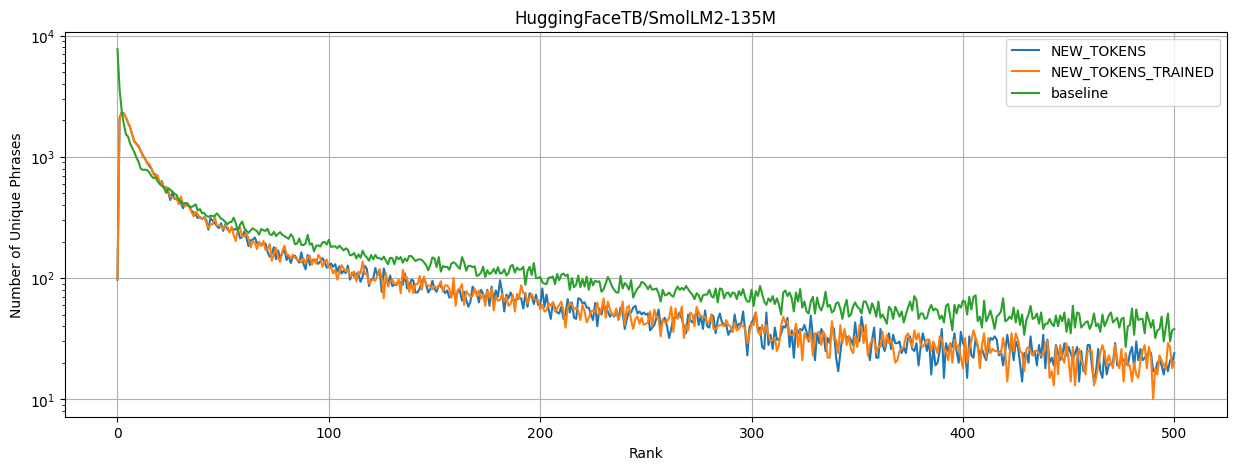

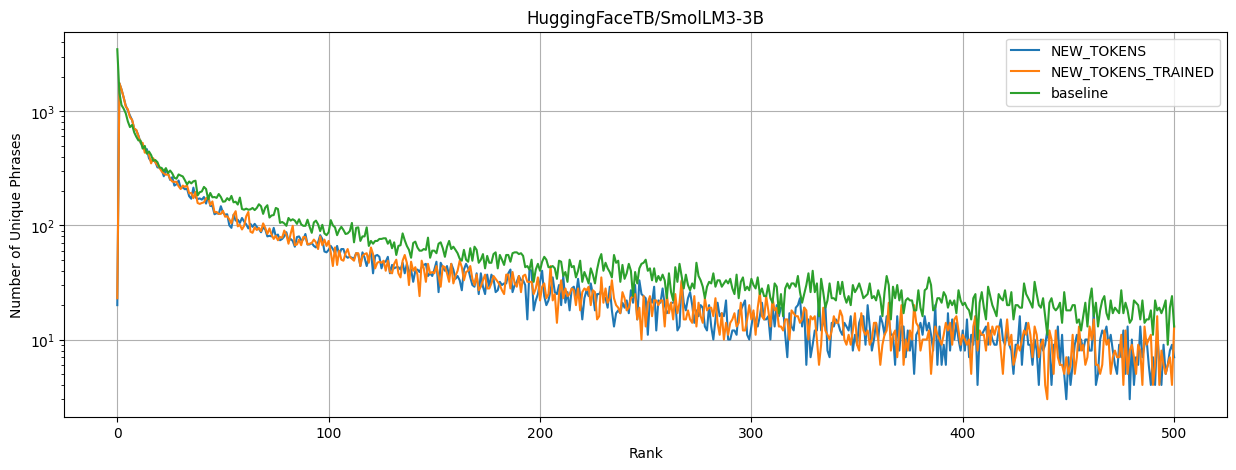

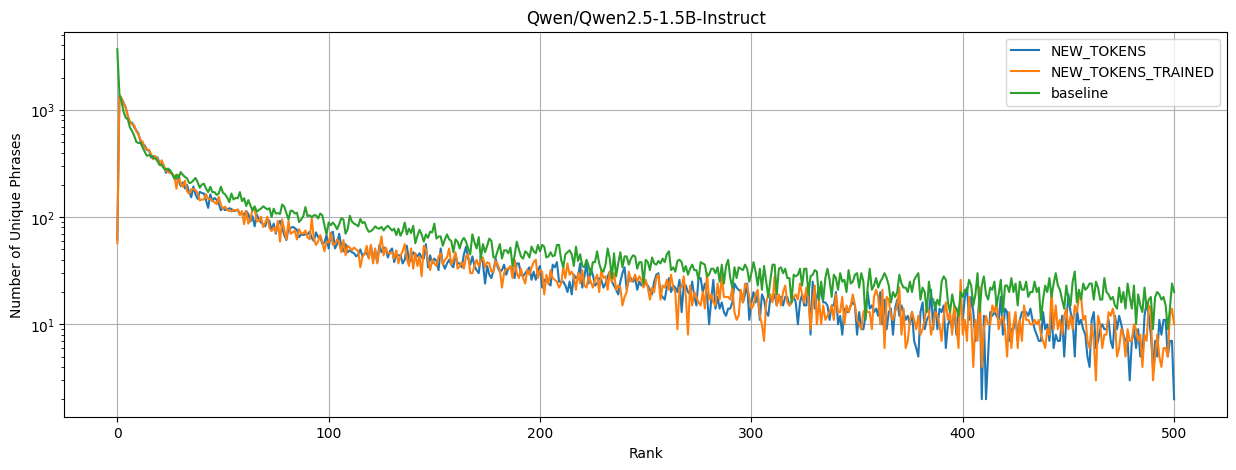

In [21]:
import matplotlib.pyplot as plt
# Ignoring everything where "rank > 500" because that is likely never going to be chosen
d = df[df[['old_token_rank', 'new_token_rank']].max(axis=1) <= 500].copy()
dist = d.groupby(by=['model', 'model_name', 'new_token_rank'], as_index=False)[['phrase']].nunique().rename(columns={'new_token_rank': 'rank'})
dist_old_tokens = d.groupby(by=['model_name', 'old_token_rank'], as_index=False)[['phrase']].nunique().rename(columns={'old_token_rank': 'rank'})

dist['type'] = dist['model'].str.split('[', n=1).str[1].str[:-1]
dist_old_tokens['type'] = 'baseline'

dist = pd.concat([dist, dist_old_tokens])
grouper = dist.groupby(by=['model_name'])
for model_name, group in dist.groupby('model_name'):
    plt.figure(figsize=(15, 5))
    for t in group['type'].unique():
        sub = group[group['type'] == t]
        plt.plot(sub['rank'], sub['phrase'],label=t)
    plt.title(model_name)
    plt.xlabel('Rank')
    plt.ylabel('Number of Unique Phrases')
    plt.yscale('log')  # <-- Logarithmic y-axis
    plt.legend()
    plt.grid(True)
    plt.show()

### Rank Difference Distribution

Since for each data-point we know what the `rank` of both `old_token` and `new_token`, we can directly compare them for each generation.

In this section, we will do exactly that and compare the number of instances where `Rank(new_token)` > `Rank(old_token)` (and vice-versa, by computing a whiskers graph)

#### OPTION 1: Box plots

/tmp/ipykernel_9444/2494590625.py:20: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



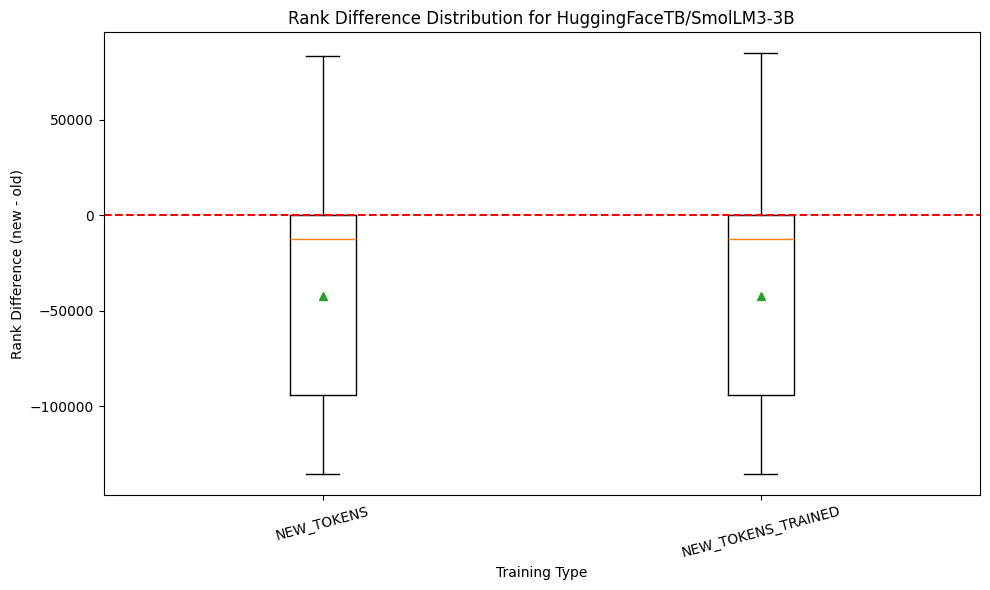

/tmp/ipykernel_9444/2494590625.py:20: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



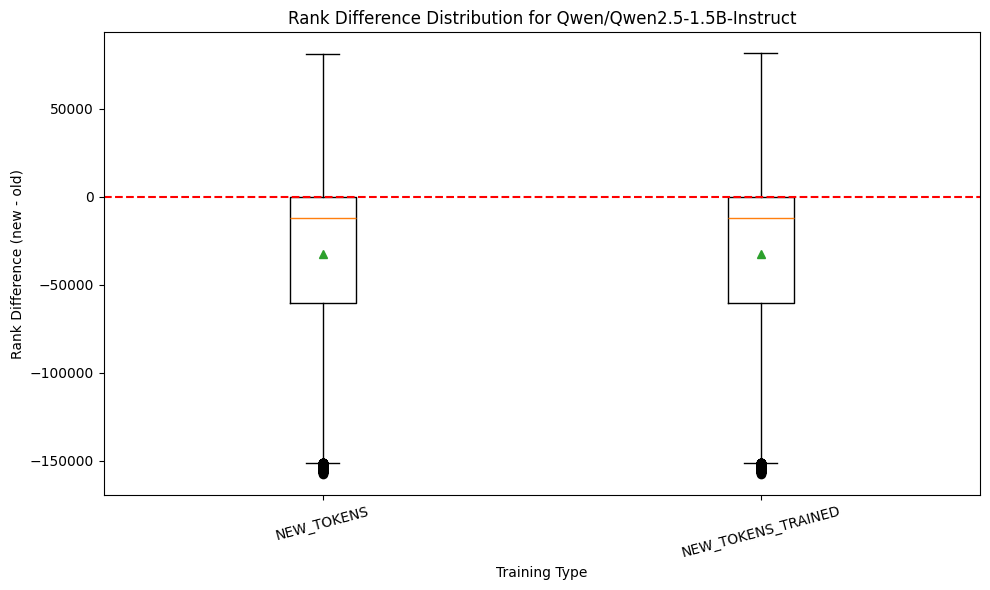

/tmp/ipykernel_9444/2494590625.py:20: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



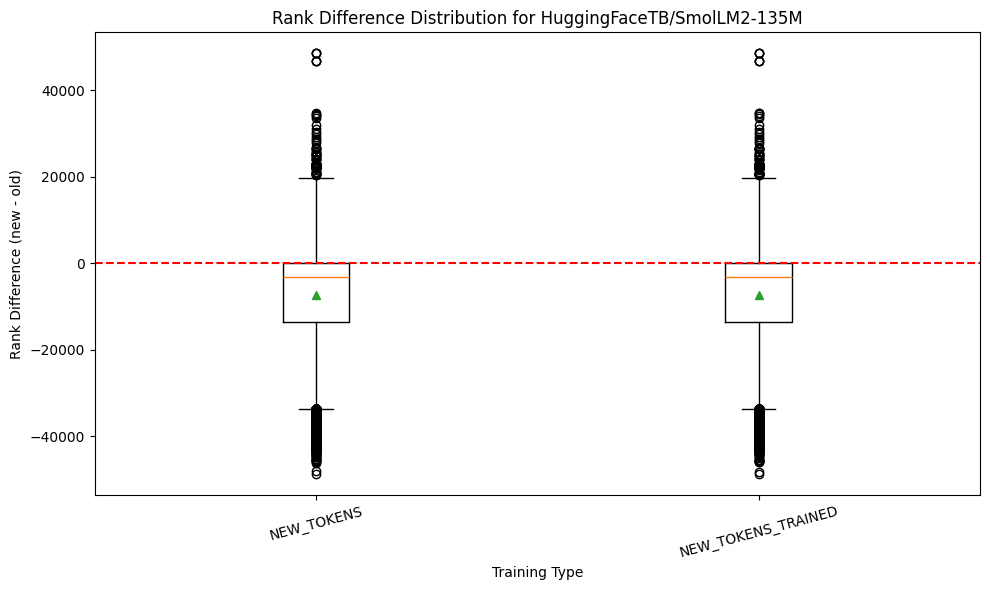

In [14]:
import matplotlib.pyplot as plt
box = df.copy()
box['rank_diff'] = (box['new_token_rank'] - box['old_token_rank'])
box['type'] = box['model'].str.split('[', n=1).str[1].str[:-1]
# Unique models
for model in box['model_name'].unique():
    # Filter data for this model
    df_model = box[box['model_name'] == model]
    
    # Get unique training types
    types = df_model['type'].unique()
    
    # Prepare data for boxplot: one list per type
    data = [df_model[df_model['type'] == t]['rank_diff'] for t in types]
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Boxplot
    plt.boxplot(data, labels=types, showmeans=True)
    
    # Reference line at 0
    plt.axhline(y=0, color='red', linestyle='--')
    
    # Labels and title
    plt.ylabel("Rank Difference (new - old)")
    plt.xlabel("Training Type")
    plt.title(f"Rank Difference Distribution for {model}")
    
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()


#### OPTION 2: Violin Plot

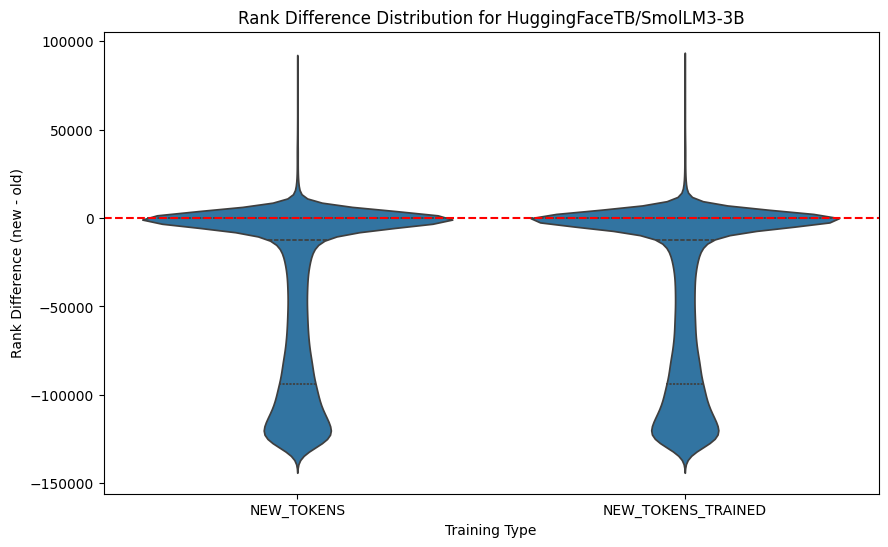

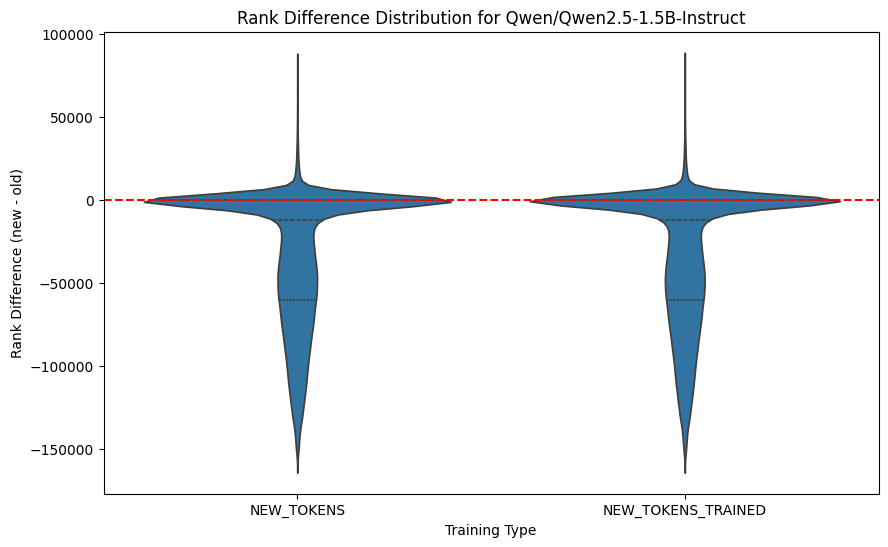

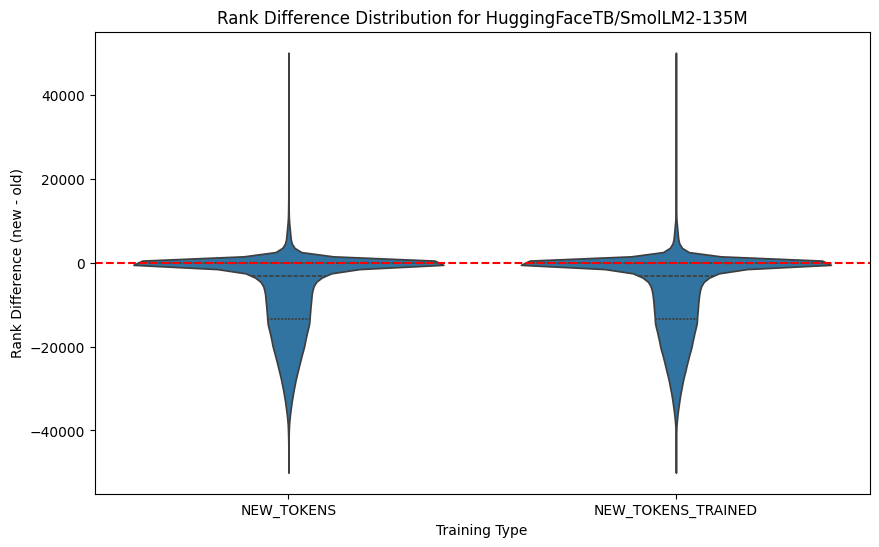

In [15]:
import seaborn as sns

# Unique models
for model in box['model_name'].unique():
    # Filter data for this model
    df_model = box[box['model_name'] == model]
    
    plt.figure(figsize=(10,6))
    sns.violinplot(x='type', y='rank_diff', data=df_model, inner='quartile')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Rank Difference Distribution for {model}")
    plt.ylabel("Rank Difference (new - old)")
    plt.xlabel("Training Type")
    plt.show()
